<a href="https://colab.research.google.com/github/Kalisa21/legalEase/blob/main/legalEase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
================================================================================
LEGAL CHATBOT PROJECT - PART 1: SETUP & DATA EXPLORATION
================================================================================

"""

In [ ]:
# ============================================================================
# CELL 1: Install Required Packages (NO VERSION NUMBERS)
# ============================================================================
print(" Installing required packages...")

!pip install -q transformers
!pip install -q torch
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q datasets
!pip install -q pandas
!pip install -q numpy
!pip install -q scikit-learn
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q plotly
!pip install -q wordcloud
!pip install -q tqdm

print(" All packages installed successfully!")

 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 56.0 MB/s eta 0:00:00
 All packages installed successfully!


In [ ]:
# CELL 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import json
from collections import Counter
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(" Libraries imported successfully!")


 Libraries imported successfully!


In [ ]:
# CELL 3: Upload and Load Dataset
# ============================================================================

from google.colab import files

# Load the dataset
df = pd.read_csv('/content/law - Sheet1.csv')

print("\n Dataset loaded successfully!")
print(f"\n Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Columns: {list(df.columns)}")



 Dataset loaded successfully!

 Dataset Shape: 304 rows × 5 columns

 Columns: ['id', 'article_label', 'article_text', 'keywords_synonyms', 'language']


In [ ]:
# CELL 4: Initial Data Exploration
# ============================================================================
print("="*80)
print("DATASET OVERVIEW")
print("="*80)

# Basic info
print(f"\n1️ BASIC STATISTICS")
print(f"   Total Rows: {len(df)}")
print(f"   Total Columns: {len(df.columns)}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Check for missing values
print(f"\n2️ DATA QUALITY")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   No missing values!")
else:
    print("    Missing values found:")
    for col, count in missing[missing > 0].items():
        print(f"      {col}: {count} ({count/len(df)*100:.2f}%)")

# Display first few rows
print(f"\n3️ SAMPLE DATA (First 3 rows)")
print(df.head(3).to_string())

# Data types
print(f"\n4️ DATA TYPES")
print(df.dtypes)


DATASET OVERVIEW

1️ BASIC STATISTICS
   Total Rows: 304
   Total Columns: 5
   Memory Usage: 433.18 KB

2️ DATA QUALITY
    Missing values found:
      id: 1 (0.33%)
      article_label: 1 (0.33%)
      article_text: 1 (0.33%)
      keywords_synonyms: 1 (0.33%)
      language: 1 (0.33%)

3️ SAMPLE DATA (First 3 rows)
    id                           article_label                                                                                                                                article_text                                                                                                                                                                                                                            keywords_synonyms language
0  1.0  Ingingo ya 1: Icyo iri tegeko rigamije                                         Iri tegeko riteganya: 1º amahame rusange agenga ibyaha n'ibihano; 2º ibyaha n'ibihano muri rusange.                                                  icyo tegeko


LANGUAGE DISTRIBUTION ANALYSIS

 Articles per Language:
   Kinyarwanda (rw): 101 rows (33.2%)
   English (en): 101 rows (33.2%)
   French (fr): 101 rows (33.2%)

 Article Structure:
   Unique article labels: 303
   Expected unique articles: 101
   Languages per article: 1


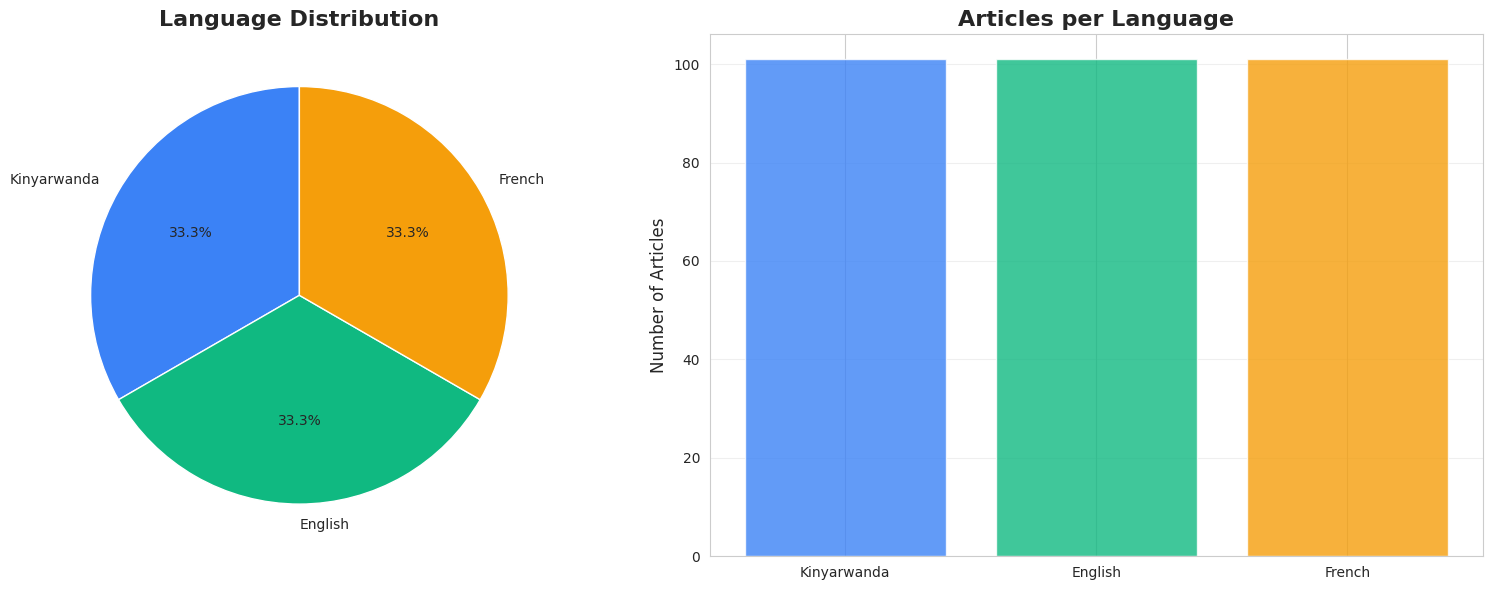


 Language analysis complete!


In [ ]:
# CELL 5: Language Distribution Analysis
# ============================================================================
print("\n" + "="*80)
print("LANGUAGE DISTRIBUTION ANALYSIS")
print("="*80)

# Count by language
lang_counts = df['language'].value_counts()
print(f"\n Articles per Language:")
for lang, count in lang_counts.items():
    lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(lang, lang)
    print(f"   {lang_name} ({lang}): {count} rows ({count/len(df)*100:.1f}%)")

# Calculate unique articles
unique_articles = df.groupby('article_label')['language'].count().value_counts()
print(f"\n Article Structure:")
print(f"   Unique article labels: {df['article_label'].nunique()}")
print(f"   Expected unique articles: {len(df) // 3}")
print(f"   Languages per article: {unique_articles.index[0] if len(unique_articles) > 0 else 'N/A'}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#3B82F6', '#10B981', '#F59E0B']
lang_names = [{'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(l, l)
              for l in lang_counts.index]
ax1.pie(lang_counts.values, labels=lang_names, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Language Distribution', fontsize=16, fontweight='bold')

# Bar chart
ax2.bar(lang_names, lang_counts.values, color=colors, alpha=0.8)
ax2.set_ylabel('Number of Articles', fontsize=12)
ax2.set_title('Articles per Language', fontsize=16, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Language analysis complete!")

In [ ]:
# CELL 6: Text Length Analysis
# ============================================================================
print("\n" + "="*80)
print("TEXT LENGTH ANALYSIS")
print("="*80)

# Calculate text lengths
df['text_length'] = df['article_text'].str.len()
df['word_count'] = df['article_text'].str.split().str.len()

# Handle potential NaN values before converting to int
df['token_estimate'] = (df['text_length'].fillna(0) / 4).astype(int)  # Rough estimate

# Statistics by language
print("\n Text Statistics by Language:\n")
stats = df.groupby('language').agg({
    'text_length': ['mean', 'min', 'max', 'std'],
    'word_count': ['mean', 'min', 'max'],
    'token_estimate': ['mean', 'min', 'max']
}).round(2)

print(stats.to_string())

# Overall statistics
print(f"\n Overall Statistics:")
print(f"   Average text length: {df['text_length'].mean():.0f} characters")
print(f"   Average word count: {df['word_count'].mean():.0f} words")
print(f"   Average tokens (estimated): {df['token_estimate'].mean():.0f} tokens")
print(f"   Shortest article: {df['text_length'].min()} characters")
print(f"   Longest article: {df['text_length'].max()} characters")

# Visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Text Length Distribution', 'Text Length by Language',
                   'Word Count Distribution', 'Token Estimate by Language'),
    specs=[[{'type': 'histogram'}, {'type': 'box'}],
           [{'type': 'histogram'}, {'type': 'box'}]]
)

# Text length histogram
fig.add_trace(
    go.Histogram(x=df['text_length'], nbinsx=30, name='Text Length',
                marker_color='#3B82F6'),
    row=1, col=1
)

# Text length by language box plot
for lang in df['language'].unique():
    lang_data = df[df['language'] == lang]
    fig.add_trace(
        go.Box(y=lang_data['text_length'], name=lang,
              marker_color={'en': '#3B82F6', 'fr': '#10B981', 'rw': '#F59E0B'}.get(lang)),
        row=1, col=2
    )

# Word count histogram
fig.add_trace(
    go.Histogram(x=df['word_count'], nbinsx=30, name='Word Count',
                marker_color='#10B981'),
    row=2, col=1
)

# Token estimate by language box plot
for lang in df['language'].unique():
    lang_data = df[df['language'] == lang]
    fig.add_trace(
        go.Box(y=lang_data['token_estimate'], name=lang, showlegend=False,
              marker_color={'en': '#3B82F6', 'fr': '#10B981', 'rw': '#F59E0B'}.get(lang)),
        row=2, col=2
    )

fig.update_layout(height=800, showlegend=True, title_text="Text Length Analysis")
fig.show()

print("\n Text length analysis complete!")


TEXT LENGTH ANALYSIS

 Text Statistics by Language:

         text_length                       word_count             token_estimate         
                mean   min     max     std       mean  min    max           mean min  max
language                                                                                 
en            420.10  43.0  2667.0  407.87      69.96  8.0  412.0         104.62  10  666
fr            436.91  47.0  2585.0  395.07      69.80  9.0  429.0         108.80  11  646
rw            390.69  37.0  2301.0  351.17      51.44  5.0  289.0          97.25   9  575

 Overall Statistics:
   Average text length: 416 characters
   Average word count: 64 words
   Average tokens (estimated): 103 tokens
   Shortest article: 37.0 characters
   Longest article: 2667.0 characters



 Text length analysis complete!



KEYWORD & SYNONYM ANALYSIS

 Keyword Statistics:
   Total keywords across all articles: 11287.0
   Average keywords per article: 37.3
   Min keywords: 11.0
   Max keywords: 111.0
   Median keywords: 36.0

   Unique keywords (across all languages): 7642

 Top 20 Most Common Keywords:
   igihano                        →  26 occurrences
   icyaha                         →  24 occurrences
   igifungo                       →  21 occurrences
   life imprisonment              →  20 occurrences
   itegeko                        →  18 occurrences
   compulsory residence particular location →  17 occurrences
   igihe                          →  14 occurrences
   ihazabu                        →  14 occurrences
   acts referred to items         →  14 occurrences
   fine                           →  13 occurrences
   imyaka                         →  12 occurrences
   urukiko                        →  12 occurrences
   amategeko                      →  11 occurrences
   burundu                   

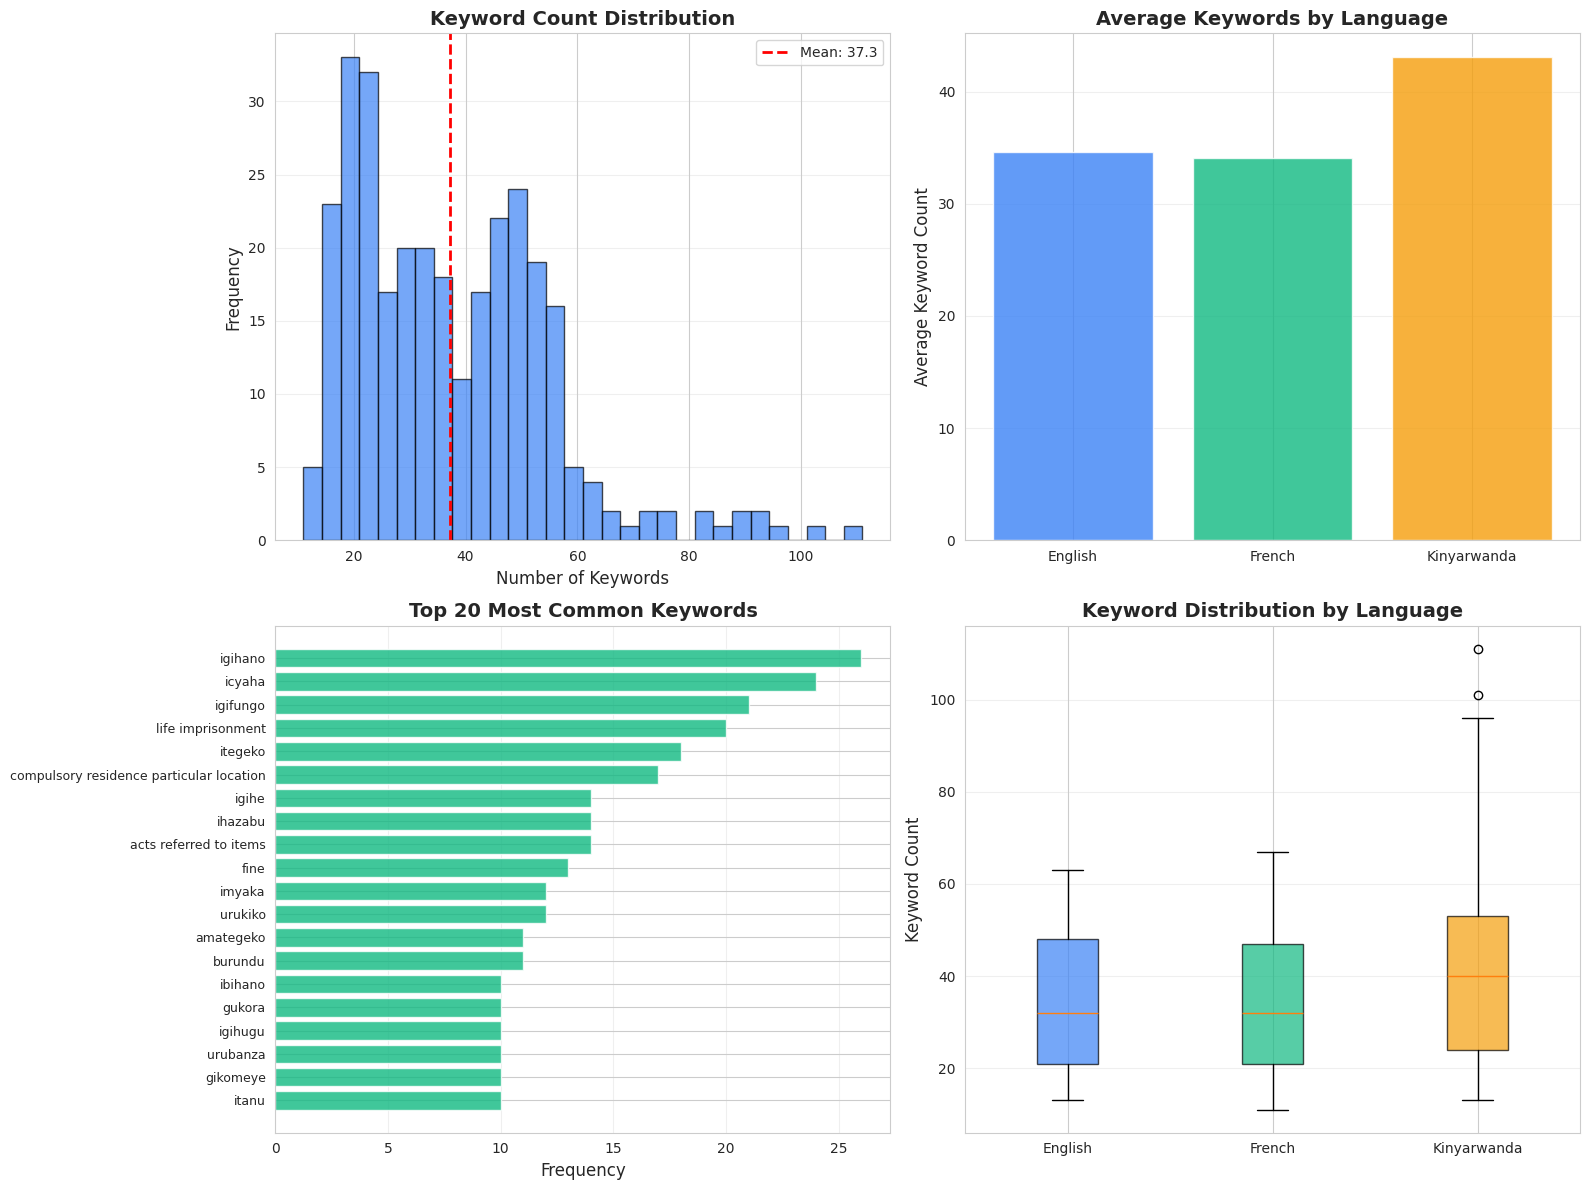


 Keyword analysis complete!


In [ ]:
# CELL 7: Keyword Analysis
# ============================================================================
print("\n" + "="*80)
print("KEYWORD & SYNONYM ANALYSIS")
print("="*80)

# Calculate keyword statistics
df['keyword_count'] = df['keywords_synonyms'].str.split(',').str.len()

print(f"\n Keyword Statistics:")
print(f"   Total keywords across all articles: {df['keyword_count'].sum()}")
print(f"   Average keywords per article: {df['keyword_count'].mean():.1f}")
print(f"   Min keywords: {df['keyword_count'].min()}")
print(f"   Max keywords: {df['keyword_count'].max()}")
print(f"   Median keywords: {df['keyword_count'].median():.1f}")

# Extract all unique keywords
all_keywords = []
for keywords_str in df['keywords_synonyms']:
    if pd.notna(keywords_str):
        keywords = [k.strip() for k in keywords_str.split(',')]
        all_keywords.extend(keywords)

unique_keywords = set(all_keywords)
print(f"\n   Unique keywords (across all languages): {len(unique_keywords)}")

# Most common keywords
keyword_freq = Counter(all_keywords)
print(f"\n Top 20 Most Common Keywords:")
for keyword, count in keyword_freq.most_common(20):
    print(f"   {keyword:30} → {count:3} occurrences")

# Keyword distribution by language
print(f"\n Keywords by Language:")
for lang in ['en', 'fr', 'rw']:
    lang_df = df[df['language'] == lang]
    lang_keywords = []
    for kw_str in lang_df['keywords_synonyms']:
        if pd.notna(kw_str):
            lang_keywords.extend([k.strip() for k in kw_str.split(',')])
    lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}[lang]
    print(f"   {lang_name}: {len(set(lang_keywords))} unique keywords")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Keyword count distribution
axes[0, 0].hist(df['keyword_count'], bins=30, color='#3B82F6', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df['keyword_count'].mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {df["keyword_count"].mean():.1f}')
axes[0, 0].set_xlabel('Number of Keywords', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Keyword Count Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Keyword count by language
lang_groups = df.groupby('language')['keyword_count'].mean()
lang_names = [{'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}[l] for l in lang_groups.index]
colors = ['#3B82F6', '#10B981', '#F59E0B']
axes[0, 1].bar(lang_names, lang_groups.values, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('Average Keyword Count', fontsize=12)
axes[0, 1].set_title('Average Keywords by Language', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Top keywords bar chart
top_20 = keyword_freq.most_common(20)
keywords, counts = zip(*top_20)
axes[1, 0].barh(range(len(keywords)), counts, color='#10B981', alpha=0.8)
axes[1, 0].set_yticks(range(len(keywords)))
axes[1, 0].set_yticklabels(keywords, fontsize=9)
axes[1, 0].set_xlabel('Frequency', fontsize=12)
axes[1, 0].set_title('Top 20 Most Common Keywords', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Keyword count box plot by language
data_to_plot = [df[df['language'] == lang]['keyword_count'].values for lang in ['en', 'fr', 'rw']]
bp = axes[1, 1].boxplot(data_to_plot, labels=['English', 'French', 'Kinyarwanda'],
                        patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Keyword Count', fontsize=12)
axes[1, 1].set_title('Keyword Distribution by Language', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Keyword analysis complete!")


WORD CLOUD GENERATION


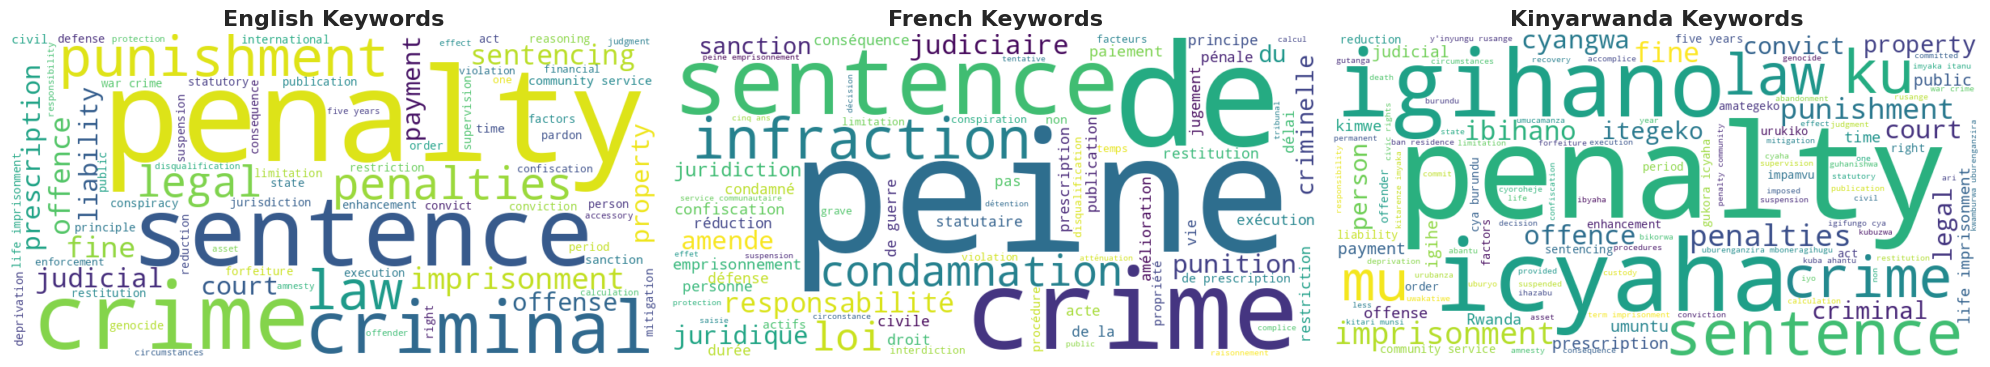


 Word clouds generated!


In [ ]:
# CELL 8: Generate Word Cloud
# ============================================================================
print("\n" + "="*80)
print("WORD CLOUD GENERATION")
print("="*80)

from wordcloud import WordCloud

# Generate word clouds for each language
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (lang, lang_name) in enumerate([('en', 'English'), ('fr', 'French'), ('rw', 'Kinyarwanda')]):
    # Get keywords for this language
    lang_df = df[df['language'] == lang]
    lang_keywords = []
    for kw_str in lang_df['keywords_synonyms']:
        if pd.notna(kw_str):
            lang_keywords.extend([k.strip() for k in kw_str.split(',')])

    # Create word cloud
    text = ' '.join(lang_keywords)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         colormap='viridis', relative_scaling=0.5,
                         min_font_size=10).generate(text)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{lang_name} Keywords', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n Word clouds generated!")

In [ ]:
# CELL 9: Article Structure Analysis
# ============================================================================
print("\n" + "="*80)
print("ARTICLE STRUCTURE ANALYSIS")
print("="*80)

# Analyze article numbering
df['article_number'] = df['article_label'].str.extract(r'(\d+)').astype(float)

print(f"\n Article Coverage:")
print(f"   Total unique article labels: {df['article_label'].nunique()}")
print(f"   Article numbers range: {df['article_number'].min():.0f} to {df['article_number'].max():.0f}")
print(f"   Total articles covered: {int(df['article_number'].nunique())}")

# Check for gaps in article numbering
article_numbers = sorted(df['article_number'].dropna().unique())
gaps = []
for i in range(len(article_numbers) - 1):
    if article_numbers[i+1] - article_numbers[i] > 1:
        gaps.append((int(article_numbers[i]), int(article_numbers[i+1])))

if gaps:
    print(f"\n  Gaps found in article numbering:")
    for start, end in gaps:
        print(f"   Gap between Article {start} and {end}")
else:
    print(f"\n No gaps in article numbering - consecutive coverage!")

# Distribution of articles
print(f"\n Article Distribution:")
article_dist = df.groupby('article_number').size()
print(f"   Most articles have {article_dist.mode()[0]:.0f} language versions")
print(f"   {(article_dist == 3).sum()} articles have all 3 languages")
print(f"   {(article_dist < 3).sum()} articles have incomplete translations")

# Sample article labels
print(f"\n Sample Article Labels:")
for label in df['article_label'].unique()[:10]:
    print(f"   • {label}")

print("\n Article structure analysis complete!")


ARTICLE STRUCTURE ANALYSIS

 Article Coverage:
   Total unique article labels: 303
   Article numbers range: 1 to 101
   Total articles covered: 101

 No gaps in article numbering - consecutive coverage!

 Article Distribution:
   Most articles have 3 language versions
   101 articles have all 3 languages
   0 articles have incomplete translations

 Sample Article Labels:
   • Ingingo ya 1: Icyo iri tegeko rigamije
   • Article 1: Purpose of this Law
   • Article 1: Objet de la présente loi
   • Ingingo ya 2: Ibisobanuro by'amagambo
   • Article 2: Definitions
   • Article 2: Définitions
   • Ingingo ya 3: Nta gihano hatari itegeko
   • Article 3: No punishment without law
   • Article 3: Pas de peine sans loi
   • Ingingo ya 4: Ikoreshwa ry'amategeko ahana

 Article structure analysis complete!


In [ ]:
# CELL 10: Comprehensive Summary Statistics
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE DATASET SUMMARY")
print("="*80)

summary = {
    'Total Rows': len(df),
    'Total Columns': len(df.columns),
    'Unique Articles': int(df['article_number'].nunique()),
    'Languages': len(df['language'].unique()),
    'Total Keywords': df['keyword_count'].sum(),
    'Unique Keywords': len(unique_keywords),
    'Avg Text Length': f"{df['text_length'].mean():.0f} chars",
    'Avg Word Count': f"{df['word_count'].mean():.0f} words",
    'Avg Keywords per Article': f"{df['keyword_count'].mean():.1f}",
    'Data Completeness': f"{(1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.1f}%",
    'Memory Usage': f"{df.memory_usage(deep=True).sum() / 1024:.2f} KB"
}

print("\n KEY STATISTICS:")
for key, value in summary.items():
    print(f"   {key:.<35} {value}")

# Estimated training data
estimated_qa_pairs = df['keyword_count'].sum() * 10  # 10 question templates per keyword
print(f"\n TRAINING DATA ESTIMATION:")
print(f"   Estimated QA pairs (10 templates): {estimated_qa_pairs:,}")
print(f"   Per language: ~{estimated_qa_pairs // 3:,} pairs")
print(f"   This is EXCELLENT for training! ")

# Save summary to file
summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])
summary_df.to_csv('dataset_summary.csv', index=False)
print(f"\n Summary saved to 'dataset_summary.csv'")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE!")
print("="*80)

print(" All visualizations and statistics have been generated.")



COMPREHENSIVE DATASET SUMMARY

 KEY STATISTICS:
   Total Rows......................... 304
   Total Columns...................... 10
   Unique Articles.................... 101
   Languages.......................... 4
   Total Keywords..................... 11287.0
   Unique Keywords.................... 7642
   Avg Text Length.................... 416 chars
   Avg Word Count..................... 64 words
   Avg Keywords per Article........... 37.3
   Data Completeness.................. 99.7%
   Memory Usage....................... 445.06 KB

 TRAINING DATA ESTIMATION:
   Estimated QA pairs (10 templates): 112,870.0
   Per language: ~37,623.0 pairs
   This is EXCELLENT for training! 

 Summary saved to 'dataset_summary.csv'

DATA EXPLORATION COMPLETE!
 All visualizations and statistics have been generated.


In [ ]:
# ============================================================================
# CELL 11: Fix Missing Language Values (AUTO-FIX)
# ============================================================================
print("\n" + "="*80)
print("DATA QUALITY CHECK & AUTO-FIX")
print("="*80)

# Check for missing language values
null_count = df['language'].isnull().sum()

if null_count > 0:
    print(f"\n  Found {null_count} row(s) with missing language value")
    print(" Auto-fixing...\n")

    null_rows = df[df['language'].isnull()]

    for idx in null_rows.index:
        article_label = str(df.loc[idx, 'article_label'])
        row_id = df.loc[idx, 'id']

        print(f"   Row {idx} (ID {row_id}): {article_label[:50]}...")

        # Detect language from article label
        if 'Ingingo' in article_label or 'tegeko' in article_label:
            df.loc[idx, 'language'] = 'rw'
            print(f"       Set to 'rw' (Kinyarwanda)")
        elif 'Article' in article_label and any(word in article_label.lower() for word in ['loi', 'peine', 'infraction', 'lorsqu']):
            df.loc[idx, 'language'] = 'fr'
            print(f"       Set to 'fr' (French)")
        else:
            df.loc[idx, 'language'] = 'en'
            print(f"       Set to 'en' (English)")

    print(f"\n All missing language values fixed!")
else:
    print("\n No missing language values found!")

# Final verification
print("\n FINAL LANGUAGE DISTRIBUTION:")
lang_counts = df['language'].value_counts()
for lang, count in lang_counts.items():
    lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(lang, lang)
    print(f"   {lang_name}: {count} rows")

print(f"\n   Total languages: {df['language'].nunique()}")
print(f"   Missing values: {df['language'].isnull().sum()}")

print("\n" + "="*80)
print(" DATA QUALITY CHECK COMPLETE - READY FOR PART 2!")
print("="*80)


DATA QUALITY CHECK & AUTO-FIX

 No missing language values found!

 FINAL LANGUAGE DISTRIBUTION:
   English: 102 rows
   Kinyarwanda: 101 rows
   French: 101 rows

   Total languages: 3
   Missing values: 0

 DATA QUALITY CHECK COMPLETE - READY FOR PART 2!


"""
================================================================================
LEGAL CHATBOT PROJECT - PART 2: DATA PROCESSING & QA PAIR GENERATION
================================================================================

This notebook processes legal dataset and generates training data:
- Converts keywords to questions (10 templates per keyword)
- Extracts answer spans from article text
- Creates intent classification dataset
- Splits data into train/val/test sets
- Saves in format ready for BERT training

Prerequisites: Run Part 1 first to load the dataset
================================================================================
"""

In [ ]:
# ============================================================================
# CELL 7: Keyword to Question Converter (OPTIMIZED - Less Redundancy)
# ============================================================================
print("="*80)
print("KEYWORD TO QUESTION CONVERSION (OPTIMIZED)")
print("="*80)

class KeywordToQuestionConverter:
    """Converts keywords into natural questions (language-specific)"""

    def __init__(self):
        # REDUCED to 3 diverse templates per language (was 10)
        self.templates = {
            'en': [
                "what is {keyword}",      # Definitional
                "explain {keyword}",       # Explanatory
                "tell me about {keyword}", # Conversational
            ],
            'fr': [
                "qu'est-ce que {keyword}",  # Definitional
                "expliquer {keyword}",      # Explanatory
                "parlez-moi de {keyword}",  # Conversational
            ],
            'rw': [
                "{keyword} ni iki",         # Definitional
                "sobanura {keyword}",       # Explanatory
                "kubwira {keyword}",        # Conversational
            ]
        }

    def generate_questions(self, keyword: str, language: str) -> List[str]:
        """Generate language-specific question variations"""
        keyword = keyword.strip().lower()
        if not keyword or language not in self.templates:
            return []

        questions = []
        templates = self.templates[language]

        for template in templates:
            question = template.format(keyword=keyword)
            questions.append(question)

        return questions

    def process_dataset(self, df: pd.DataFrame, verbose: bool = True) -> List[Dict]:
        """Process entire dataset with language awareness"""
        all_questions = []

        for idx, row in df.iterrows():
            # Extract info
            keywords_str = row['keywords_synonyms']
            language = row['language']

            if pd.isna(keywords_str) or pd.isna(language):
                continue

            keywords = [k.strip() for k in keywords_str.split(',')]

            for keyword in keywords:
                if not keyword:
                    continue

                # Generate language-specific questions
                questions = self.generate_questions(keyword, language)

                for question in questions:
                    all_questions.append({
                        'article_id': row['id'],
                        'article_label': row['article_label'],
                        'article_text': row['article_text'],
                        'keyword': keyword,
                        'question': question,
                        'language': language
                    })

        if verbose:
            print(f"\nGenerated {len(all_questions):,} questions from {len(df)} articles")
            print(f"   Questions per language:")
            lang_counts = {}
            for q in all_questions:
                lang = q['language']
                lang_counts[lang] = lang_counts.get(lang, 0) + 1
            for lang, count in sorted(lang_counts.items()):
                lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}.get(lang, lang)
                print(f"     {lang_name}: {count:,}")

        return all_questions

# Initialize converter
converter = KeywordToQuestionConverter()

# Generate questions
print("\nProcessing dataset with optimized templates...")
all_questions = converter.process_dataset(df, verbose=True)

# Show examples from each language
print(f"\nSample Generated Questions:")
print("\n   ENGLISH Examples:")
en_samples = [q for q in all_questions if q['language'] == 'en'][:5]
for i, q in enumerate(en_samples, 1):
    print(f"   {i}. \"{q['question']}\" [en]")

print("\n   FRENCH Examples:")
fr_samples = [q for q in all_questions if q['language'] == 'fr'][:5]
for i, q in enumerate(fr_samples, 1):
    print(f"   {i}. \"{q['question']}\" [fr]")

print("\n   KINYARWANDA Examples:")
rw_samples = [q for q in all_questions if q['language'] == 'rw'][:5]
for i, q in enumerate(rw_samples, 1):
    print(f"   {i}. \"{q['question']}\" [rw]")

print("\nQuestion generation complete!")

KEYWORD TO QUESTION CONVERSION (OPTIMIZED)

Processing dataset with optimized templates...

Generated 33,861 questions from 304 articles
   Questions per language:
     English: 10,482
     French: 10,332
     Kinyarwanda: 13,047

Sample Generated Questions:

   ENGLISH Examples:
   1. "what is purpose of law" [en]
   2. "explain purpose of law" [en]
   3. "tell me about purpose of law" [en]
   4. "what is purpose" [en]
   5. "explain purpose" [en]

   FRENCH Examples:
   1. "qu'est-ce que objet de la loi" [fr]
   2. "expliquer objet de la loi" [fr]
   3. "parlez-moi de objet de la loi" [fr]
   4. "qu'est-ce que présente loi" [fr]
   5. "expliquer présente loi" [fr]

   KINYARWANDA Examples:
   1. "icyo tegeko rigamije ni iki" [rw]
   2. "sobanura icyo tegeko rigamije" [rw]
   3. "kubwira icyo tegeko rigamije" [rw]
   4. "intego y'itegeko ni iki" [rw]
   5. "sobanura intego y'itegeko" [rw]

Question generation complete!


In [ ]:
# ============================================================================
# CELL 8: Answer Span Extractor
# ============================================================================
print("\n" + "="*80)
print("ANSWER SPAN EXTRACTION")
print("="*80)

import re
from typing import Optional, Dict, List

class AnswerSpanExtractor:
    """Extracts answer spans from legal article text"""

    def __init__(self):
        # Patterns for finding definitions in legal text
        self.definition_patterns = [
            # Pattern 1: "keyword: definition;"
            r'{keyword}\s*:\s*([^;\.]+[;\.?!]?)',
            # Pattern 2: "keyword means definition"
            r'{keyword}\s+(means?|est|signifie)\s+([^;\.]+[;\.?!]?)',
            # Pattern 3: "keyword is/are definition"
            r'{keyword}\s+(is|are|sont?)\s+([^;\.]+[;\.?!]?)',
            # Pattern 4: Numbered definition "1º keyword: definition"
            r'\d+[ºo°]\s*{keyword}\s*:\s*([^;\.]+[;\.?!]?)',
        ]

    def normalize_keyword(self, keyword: str) -> str:
        """Normalize keyword for pattern matching"""
        keyword = re.sub(r'[^\w\s\-áéíóúàèìòùâêîôûäëïöüç]', '', keyword, flags=re.UNICODE)
        return keyword.strip()

    def find_answer_span(self, keyword: str, context: str, language: str) -> Optional[Dict]:
        """Find answer span for a keyword in context"""
        keyword_normalized = self.normalize_keyword(keyword)
        keyword_escaped = re.escape(keyword_normalized)

        # Try each pattern
        for pattern_template in self.definition_patterns:
            pattern = pattern_template.format(keyword=keyword_escaped)
            match = re.search(pattern, context, re.IGNORECASE | re.UNICODE)

            if match:
                answer_text = match.group(match.lastindex) if match.lastindex else match.group(0)
                answer_text = answer_text.strip().rstrip(';.?!')

                if 10 <= len(answer_text) <= 800:
                    answer_start = context.lower().find(answer_text.lower())
                    if answer_start != -1:
                        actual_text = context[answer_start:answer_start + len(answer_text)]
                        return {
                            'text': actual_text.strip(),
                            'answer_start': answer_start,
                            'answer_end': answer_start + len(actual_text)
                        }

        # Fallback: Extract sentence containing keyword
        keyword_pos = context.lower().find(keyword_normalized.lower())
        if keyword_pos != -1:
            sentence = self._extract_sentence(context, keyword_pos)
            if sentence and 20 <= len(sentence) <= 800:
                answer_start = context.find(sentence)
                if answer_start != -1:
                    return {
                        'text': sentence.strip(),
                        'answer_start': answer_start,
                        'answer_end': answer_start + len(sentence)
                    }

        return None

    def _extract_sentence(self, text: str, pos: int) -> Optional[str]:
        """Extract sentence containing the position"""
        sentence_end_chars = ['.', ';', '!', '?', '\n']

        # Find start
        start = 0
        for i in range(pos - 1, -1, -1):
            if text[i] in sentence_end_chars:
                start = i + 1
                break

        # Find end
        end = len(text)
        for i in range(pos, len(text)):
            if text[i] in sentence_end_chars:
                end = i + 1
                break

        sentence = text[start:end].strip()
        return sentence if len(sentence) > 15 else None

    def process_questions(self, questions: List[Dict], verbose: bool = True) -> List[Dict]:
        """Process all questions and extract answer spans"""
        qa_pairs = []
        failed_extractions = 0

        for i, q in enumerate(questions):
            if verbose and (i + 1) % 1000 == 0:
                print(f"   Processed {i + 1:,}/{len(questions):,} questions...")

            answer_span = self.find_answer_span(
                keyword=q['keyword'],
                context=q['article_text'],
                language=q['language']
            )

            if answer_span:
                qa_pairs.append({
                    'id': f"qa_{len(qa_pairs)}",
                    'article_id': q['article_id'],
                    'article_label': q['article_label'],
                    'question': q['question'],
                    'context': q['article_text'],
                    'answer': {
                        'text': answer_span['text'],
                        'answer_start': answer_span['answer_start']
                    },
                    'language': q['language'],
                    'keyword': q['keyword']
                })
            else:
                failed_extractions += 1

        if verbose:
            print(f"\nSuccessfully extracted {len(qa_pairs):,} QA pairs")
            print(f"   Failed extractions: {failed_extractions:,} ({failed_extractions/len(questions)*100:.1f}%)")
            print(f"   Success rate: {len(qa_pairs)/len(questions)*100:.1f}%")

        return qa_pairs

# Initialize extractor
extractor = AnswerSpanExtractor()

# Extract answer spans
print("\nExtracting answer spans from articles...")
qa_pairs = extractor.process_questions(all_questions, verbose=True)

# Show examples
print(f"\nSample QA Pairs:")
for i, qa in enumerate(qa_pairs[:3], 1):
    print(f"\n   {i}. Question: \"{qa['question']}\"")
    print(f"      Answer: \"{qa['answer']['text'][:150]}...\"")
    print(f"      Answer length: {len(qa['answer']['text'])} chars")
    print(f"      Source: {qa['article_label']} [{qa['language']}]")

print("\nAnswer span extraction complete!")


ANSWER SPAN EXTRACTION

Extracting answer spans from articles...
   Processed 1,000/33,861 questions...
   Processed 2,000/33,861 questions...
   Processed 3,000/33,861 questions...
   Processed 4,000/33,861 questions...
   Processed 5,000/33,861 questions...
   Processed 6,000/33,861 questions...
   Processed 7,000/33,861 questions...
   Processed 8,000/33,861 questions...
   Processed 9,000/33,861 questions...
   Processed 10,000/33,861 questions...
   Processed 11,000/33,861 questions...
   Processed 12,000/33,861 questions...
   Processed 13,000/33,861 questions...
   Processed 14,000/33,861 questions...
   Processed 15,000/33,861 questions...
   Processed 16,000/33,861 questions...
   Processed 17,000/33,861 questions...
   Processed 18,000/33,861 questions...
   Processed 19,000/33,861 questions...
   Processed 20,000/33,861 questions...
   Processed 21,000/33,861 questions...
   Processed 22,000/33,861 questions...
   Processed 23,000/33,861 questions...
   Processed 24,000/33,

In [ ]:
# CELL 3: Create Intent Classification Dataset
# ============================================================================
print("\n" + "="*80)
print("INTENT CLASSIFICATION DATASET CREATION")
print("="*80)

def create_intent_dataset(languages: List[str] = ['en', 'fr', 'rw']) -> List[Dict]:
    """Create comprehensive intent classification dataset"""

    intent_data = []

    # ========== GREETING CLASS ==========
    greetings = {
        'en': [
            "hello", "hi", "hey", "good morning", "good afternoon",
            "good evening", "greetings", "hi there", "hello there",
            "hey there", "good day", "howdy", "yo", "hiya",
            "what's up", "how are you", "how do you do"
        ],
        'fr': [
            "bonjour", "salut", "bonsoir", "coucou", "allô",
            "bonjour à tous", "salutations", "bonne journée",
            "comment allez-vous", "ça va", "comment ça va"
        ],
        'rw': [
            "muraho", "mwaramutse", "mwiriwe", "bite", "amakuru",
            "mwaramutse neza", "mwiriwe neza", "muraho neza"
        ]
    }

    for lang in languages:
        for greeting in greetings.get(lang, []):
            intent_data.append({
                'text': greeting,
                'label': 'greeting',
                'language': lang
            })

    # ========== CLOSING CLASS ==========
    closings = {
        'en': [
            "thank you", "thanks", "bye", "goodbye", "see you",
            "see you later", "thanks a lot", "thank you very much",
            "that's all", "that's helpful", "that helps", "got it",
            "perfect", "great", "excellent", "awesome", "cheers"
        ],
        'fr': [
            "merci", "merci beaucoup", "au revoir", "à bientôt",
            "salut", "bye", "c'est tout", "parfait", "excellent",
            "d'accord", "ok merci", "merci pour l'aide"
        ],
        'rw': [
            "murakoze", "murakoze cyane", "murakozwe", "sawa",
            "byiza", "ni byiza", "ndashimiye", "tubonane"
        ]
    }

    for lang in languages:
        for closing in closings.get(lang, []):
            intent_data.append({
                'text': closing,
                'label': 'closing',
                'language': lang
            })

    # ========== OUT-OF-DOMAIN CLASS ==========
    ood_examples = {
        'en': [
            "what's the weather", "weather forecast", "temperature today",
            "tell me a joke", "funny story", "make me laugh",
            "how to cook rice", "recipe for pasta", "cooking tips",
            "latest news", "current events", "breaking news",
            "sports scores", "football results", "who won the game",
            "movie recommendations", "best films", "what to watch",
            "music playlist", "song recommendations", "play music",
            "stock prices", "market update", "bitcoin price",
            "translate this", "translation", "how do you say",
            "math problem", "calculate", "what is 2+2",
            "python code", "programming help", "how to code",
            "medical advice", "health tips", "symptoms",
            "travel tips", "vacation ideas", "where to go",
            "shopping", "buy online", "best deals",
            "restaurant recommendations", "where to eat", "food near me"
        ],
        'fr': [
            "quelle est la météo", "prévisions météo",
            "raconte une blague", "histoire drôle",
            "recette de cuisine", "comment cuisiner",
            "actualités", "dernières nouvelles",
            "résultats sportifs", "score du match",
            "recommandations de films", "que regarder",
            "musique", "playlist", "jouer de la musique",
            "prix des actions", "bourse",
            "traduire", "traduction",
            "problème de maths", "calculer",
            "code python", "programmation",
            "conseils médicaux", "santé",
            "conseils de voyage", "où aller",
            "shopping", "acheter en ligne",
            "recommandations de restaurants"
        ],
        'rw': [
            "ibihe byiza", "imvura izagwa",
            "urwenya", "inkuru",
            "guteka", "ibiryo",
            "amakuru", "inkuru",
            "siporo", "umukino",
            "filime", "kubona",
            "umuziki", "gukinisha",
            "amafaranga", "gucuruza",
            "guhindura", "ururimi",
            "kubara", "imibare",
            "kode", "programu",
            "ubuzima", "indwara",
            "urugendo", "kuja",
            "kugura", "amaduka",
            "resitora", "kurya"
        ]
    }

    for lang in languages:
        for ood in ood_examples.get(lang, []):
            intent_data.append({
                'text': ood,
                'label': 'out_of_domain',
                'language': lang
            })

    # ========== LEGAL QUESTION CLASS ==========
    # Add sample legal questions from our QA pairs
    legal_sample = [qa for qa in qa_pairs if len(qa['question']) > 5]

    # Take balanced sample from each language
    samples_per_lang = min(100, len(legal_sample) // 3)
    for lang in languages:
        lang_samples = [qa for qa in legal_sample if qa['language'] == lang]
        for qa in lang_samples[:samples_per_lang]:
            intent_data.append({
                'text': qa['question'],
                'label': 'legal_question',
                'language': qa['language']
            })

    return intent_data

# Create intent dataset
print("\n Creating intent classification dataset...")
intent_data = create_intent_dataset()

# Statistics
print(f"\n Created {len(intent_data)} intent samples")
print(f"\n Distribution by class:")
for label in ['greeting', 'legal_question', 'out_of_domain', 'closing']:
    count = sum(1 for item in intent_data if item['label'] == label)
    print(f"   {label:20} → {count:4} samples ({count/len(intent_data)*100:.1f}%)")

print(f"\n Distribution by language:")
for lang in ['en', 'fr', 'rw']:
    count = sum(1 for item in intent_data if item['language'] == lang)
    lang_name = {'en': 'English', 'fr': 'French', 'rw': 'Kinyarwanda'}[lang]
    print(f"   {lang_name:20} → {count:4} samples ({count/len(intent_data)*100:.1f}%)")

# Show examples
print(f"\n Sample Intent Data:")
for label in ['greeting', 'legal_question', 'out_of_domain', 'closing']:
    samples = [item for item in intent_data if item['label'] == label][:2]
    print(f"\n   {label.upper()}:")
    for sample in samples:
        print(f"      \"{sample['text']}\" [{sample['language']}]")

print("\n Intent dataset creation complete!")


INTENT CLASSIFICATION DATASET CREATION

 Creating intent classification dataset...

 Created 478 intent samples

 Distribution by class:
   greeting             →   36 samples (7.5%)
   legal_question       →  300 samples (62.8%)
   out_of_domain        →  105 samples (22.0%)
   closing              →   37 samples (7.7%)

 Distribution by language:
   English              →  179 samples (37.4%)
   French               →  153 samples (32.0%)
   Kinyarwanda          →  146 samples (30.5%)

 Sample Intent Data:

   GREETING:
      "hello" [en]
      "hi" [en]

   LEGAL_QUESTION:
      "what is law" [en]
      "explain law" [en]

   OUT_OF_DOMAIN:
      "what's the weather" [en]
      "weather forecast" [en]

   CLOSING:
      "thank you" [en]
      "thanks" [en]

 Intent dataset creation complete!


In [ ]:
# CELL 4: Split Data into Train/Val/Test Sets
# ============================================================================
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

from sklearn.model_selection import train_test_split

def split_dataset(data: List[Dict],
                 train_size: float = 0.70,
                 val_size: float = 0.15,
                 test_size: float = 0.15,
                 random_state: int = 42) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """Split dataset into train/val/test sets"""

    # First split: train and temp (val+test)
    train, temp = train_test_split(
        data,
        train_size=train_size,
        random_state=random_state,
        shuffle=True
    )

    # Second split: val and test from temp
    val_ratio = val_size / (val_size + test_size)
    val, test = train_test_split(
        temp,
        train_size=val_ratio,
        random_state=random_state,
        shuffle=True
    )

    return train, val, test

# Split QA dataset
print("\n Splitting QA dataset (70/15/15)...")
qa_train, qa_val, qa_test = split_dataset(qa_pairs)

print(f"\n QA Dataset Split:")
print(f"   Train: {len(qa_train):,} pairs ({len(qa_train)/len(qa_pairs)*100:.1f}%)")
print(f"   Val:   {len(qa_val):,} pairs ({len(qa_val)/len(qa_pairs)*100:.1f}%)")
print(f"   Test:  {len(qa_test):,} pairs ({len(qa_test)/len(qa_pairs)*100:.1f}%)")

# Split Intent dataset
print("\n Splitting Intent dataset (70/15/15)...")
intent_train, intent_val, intent_test = split_dataset(intent_data)

print(f"\n Intent Dataset Split:")
print(f"   Train: {len(intent_train):,} samples ({len(intent_train)/len(intent_data)*100:.1f}%)")
print(f"   Val:   {len(intent_val):,} samples ({len(intent_val)/len(intent_data)*100:.1f}%)")
print(f"   Test:  {len(intent_test):,} samples ({len(intent_test)/len(intent_data)*100:.1f}%)")

# Verify distribution is maintained
print("\n Verifying class distribution in splits:")
for label in ['greeting', 'legal_question', 'out_of_domain', 'closing']:
    train_count = sum(1 for item in intent_train if item['label'] == label)
    val_count = sum(1 for item in intent_val if item['label'] == label)
    test_count = sum(1 for item in intent_test if item['label'] == label)
    total = train_count + val_count + test_count
    print(f"   {label:20} → Train: {train_count:3} | Val: {val_count:3} | Test: {test_count:3} | Total: {total:3}")

print("\n Data splitting complete!")


DATA SPLITTING

 Splitting QA dataset (70/15/15)...

 QA Dataset Split:
   Train: 6,484 pairs (70.0%)
   Val:   1,390 pairs (15.0%)
   Test:  1,390 pairs (15.0%)

 Splitting Intent dataset (70/15/15)...

 Intent Dataset Split:
   Train: 334 samples (69.9%)
   Val:   72 samples (15.1%)
   Test:  72 samples (15.1%)

 Verifying class distribution in splits:
   greeting             → Train:  20 | Val:   4 | Test:  12 | Total:  36
   legal_question       → Train: 216 | Val:  46 | Test:  38 | Total: 300
   out_of_domain        → Train:  73 | Val:  15 | Test:  17 | Total: 105
   closing              → Train:  25 | Val:   7 | Test:   5 | Total:  37

 Data splitting complete!


In [ ]:
# CELL 5: Convert to SQuAD Format for QA Training
# ============================================================================
print("\n" + "="*80)
print("CONVERT TO SQUAD FORMAT")
print("="*80)

def convert_to_squad_format(qa_pairs: List[Dict], split_name: str) -> Dict:
    """Convert QA pairs to SQuAD format for BERT training"""

    squad_data = {
        "version": "v2.0",
        "data": []
    }

    # Group by article
    articles = {}
    for qa in qa_pairs:
        article_label = qa['article_label']
        if article_label not in articles:
            articles[article_label] = {
                'title': article_label,
                'paragraphs': []
            }

    # Group by context (article text)
    context_groups = {}
    for qa in qa_pairs:
        context = qa['context']
        if context not in context_groups:
            context_groups[context] = {
                'context': context,
                'qas': []
            }

        context_groups[context]['qas'].append({
            'id': qa['id'],
            'question': qa['question'],
            'answers': [qa['answer']],
            'is_impossible': False
        })

    # Add to squad format
    squad_data['data'] = [{
        'title': f"Legal Articles - {split_name}",
        'paragraphs': list(context_groups.values())
    }]

    return squad_data

# Convert all splits
print("\n Converting to SQuAD format...")

squad_train = convert_to_squad_format(qa_train, "train")
squad_val = convert_to_squad_format(qa_val, "validation")
squad_test = convert_to_squad_format(qa_test, "test")

print(f"\n Conversion complete!")
print(f"   Train: {len(qa_train):,} QA pairs")
print(f"   Val:   {len(qa_val):,} QA pairs")
print(f"   Test:  {len(qa_test):,} QA pairs")


# ============================================================================
# CELL 6: Save Processed Data
# ============================================================================
print("\n" + "="*80)
print("SAVING PROCESSED DATA")
print("="*80)

import os
import json

# Create output directory
os.makedirs('processed_data', exist_ok=True)

# Save QA data (SQuAD format)
print("\n Saving QA datasets...")
with open('processed_data/qa_train.json', 'w', encoding='utf-8') as f:
    json.dump(squad_train, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/qa_train.json")

with open('processed_data/qa_val.json', 'w', encoding='utf-8') as f:
    json.dump(squad_val, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/qa_val.json")

with open('processed_data/qa_test.json', 'w', encoding='utf-8') as f:
    json.dump(squad_test, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/qa_test.json")

# Save Intent data
print("\n Saving Intent datasets...")
with open('processed_data/intent_train.json', 'w', encoding='utf-8') as f:
    json.dump(intent_train, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/intent_train.json")

with open('processed_data/intent_val.json', 'w', encoding='utf-8') as f:
    json.dump(intent_val, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/intent_val.json")

with open('processed_data/intent_test.json', 'w', encoding='utf-8') as f:
    json.dump(intent_test, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/intent_test.json")

# Save summary statistics
print("\n Saving summary statistics...")
summary_stats = {
    'dataset_info': {
        'total_articles': len(df),
        'unique_articles': int(df['article_number'].nunique()),
        'languages': list(df['language'].unique()),
        'total_keywords': int(df['keyword_count'].sum())
    },
    'qa_data': {
        'total_pairs': len(qa_pairs),
        'train': len(qa_train),
        'val': len(qa_val),
        'test': len(qa_test),
        'success_rate': f"{len(qa_pairs)/len(all_questions)*100:.1f}%"
    },
    'intent_data': {
        'total_samples': len(intent_data),
        'train': len(intent_train),
        'val': len(intent_val),
        'test': len(intent_test),
        'classes': ['greeting', 'legal_question', 'out_of_domain', 'closing']
    }
}

with open('processed_data/summary_stats.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)
print("    saved: processed_data/summary_stats.json")

print("\n" + "="*80)
print("DATA PROCESSING COMPLETE!")
print("="*80)
print(f"\n FINAL STATISTICS:")
print(f"   QA Pairs Generated: {len(qa_pairs):,}")
print(f"   Intent Samples: {len(intent_data):,}")
print(f"   Total Training Samples: {len(qa_train) + len(intent_train):,}")
print(f"\n All data saved to 'processed_data/' directory")
print(f"\n Ready to proceed to Part 3: Model Training!")
print(f" Next: Train Intent Classifier and QA Model")


CONVERT TO SQUAD FORMAT

 Converting to SQuAD format...

 Conversion complete!
   Train: 6,484 QA pairs
   Val:   1,390 QA pairs
   Test:  1,390 QA pairs

SAVING PROCESSED DATA

 Saving QA datasets...
    saved: processed_data/qa_train.json
    saved: processed_data/qa_val.json
    saved: processed_data/qa_test.json

 Saving Intent datasets...
    saved: processed_data/intent_train.json
    saved: processed_data/intent_val.json
    saved: processed_data/intent_test.json

 Saving summary statistics...
    saved: processed_data/summary_stats.json

DATA PROCESSING COMPLETE!

 FINAL STATISTICS:
   QA Pairs Generated: 9,264
   Intent Samples: 478
   Total Training Samples: 6,818

 All data saved to 'processed_data/' directory

 Ready to proceed to Part 3: Model Training!
 Next: Train Intent Classifier and QA Model


In [ ]:
# Save to Google Drive (Simple)
from google.colab import drive
import shutil

# Mount Drive
drive.mount('/content/drive')

# Copy processed_data folder to Drive
shutil.copytree('processed_data', '/content/drive/MyDrive/processed_data', dirs_exist_ok=True)

print("✅ Saved to: Google Drive/processed_data/")

Mounted at /content/drive
✅ Saved to: Google Drive/processed_data/


LEGAL CHATBOT PROJECT - PART 3: MODEL TRAINING
================================================================================

This notebook trains both models:
1. Intent Classifier (XLM-RoBERTa-base) - 4 classes
2. QA Model (XLM-RoBERTa-large-squad2) - Extractive QA

Prerequisites: Run Part 1 and Part 2 first


In [ ]:
# CELL 1: Check GPU and Import Libraries
# ============================================================================
import torch
import torch.nn as nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForQuestionAnswering,
    Trainer,
    TrainingArguments,
    default_data_collator,
    EarlyStoppingCallback
)
from datasets import Dataset, load_dataset
import json
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("="*80)
print("SYSTEM CHECK")
print("="*80)
print(f"\n  Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("    GPU is available! Training will be fast.")
else:
    print("    No GPU found. Training will be slow.")
    print("   Consider: Runtime → Change runtime type → GPU")

print("\n Libraries imported successfully!")

SYSTEM CHECK

  Device: cuda
   GPU Name: Tesla T4
   GPU Memory: 14.74 GB
    GPU is available! Training will be fast.

 Libraries imported successfully!


In [ ]:
# CELL 2: Load Processed Data
# ============================================================================
print("\n" + "="*80)
print("LOADING PROCESSED DATA")
print("="*80)

# Load Intent data
print("\n Loading Intent classification data...")
with open('/content/processed_data/intent_train.json', 'r', encoding='utf-8') as f:
    intent_train = json.load(f)
with open('/content/processed_data/intent_val.json', 'r', encoding='utf-8') as f:
    intent_val = json.load(f)
with open('/content/processed_data/intent_test.json', 'r', encoding='utf-8') as f:
    intent_test = json.load(f)

print(f"    Intent Train: {len(intent_train)} samples")
print(f"    Intent Val: {len(intent_val)} samples")
print(f"    Intent Test: {len(intent_test)} samples")

# Load QA data
print("\n Loading QA data...")
with open('/content/processed_data/qa_test.json', 'r', encoding='utf-8') as f:
    qa_train_raw = json.load(f)
with open('/content/processed_data/qa_val.json', 'r', encoding='utf-8') as f:
    qa_val_raw = json.load(f)
with open('//content/processed_data/qa_test.json', 'r', encoding='utf-8') as f:
    qa_test_raw = json.load(f)

# Count QA pairs
qa_train_count = sum(len(p['qas']) for article in qa_train_raw['data'] for p in article['paragraphs'])
qa_val_count = sum(len(p['qas']) for article in qa_val_raw['data'] for p in article['paragraphs'])
qa_test_count = sum(len(p['qas']) for article in qa_test_raw['data'] for p in article['paragraphs'])

print(f"    QA Train: {qa_train_count} pairs")
print(f"    QA Val: {qa_val_count} pairs")
print(f"    QA Test: {qa_test_count} pairs")

print("\n All data loaded successfully!")


LOADING PROCESSED DATA

 Loading Intent classification data...
    Intent Train: 334 samples
    Intent Val: 72 samples
    Intent Test: 72 samples

 Loading QA data...
    QA Train: 1390 pairs
    QA Val: 1390 pairs
    QA Test: 1390 pairs

 All data loaded successfully!


In [ ]:
# CELL 3: Train Intent Classifier
# ============================================================================
print("\n" + "="*80)
print("TRAINING INTENT CLASSIFIER")
print("="*80)

# Define label mapping
label2id = {
    'greeting': 0,
    'legal_question': 1,
    'out_of_domain': 2,
    'closing': 3
}
id2label = {v: k for k, v in label2id.items()}

print(f"\n  Classes: {list(label2id.keys())}")

# Prepare datasets
def prepare_intent_dataset(data):
    """Convert intent data to HuggingFace Dataset format"""
    texts = [item['text'] for item in data]
    labels = [label2id[item['label']] for item in data]

    return Dataset.from_dict({
        'text': texts,
        'label': labels
    })

print("\n Preparing datasets...")
intent_train_dataset = prepare_intent_dataset(intent_train)
intent_val_dataset = prepare_intent_dataset(intent_val)
intent_test_dataset = prepare_intent_dataset(intent_test)
print("    Datasets prepared!")

# Load tokenizer and model
print("\n Loading XLM-RoBERTa-base model...")
intent_model_name = 'xlm-roberta-base'
intent_tokenizer = AutoTokenizer.from_pretrained(intent_model_name)
intent_model = AutoModelForSequenceClassification.from_pretrained(
    intent_model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id
).to(device)
print("   Model loaded!")

# Tokenize datasets
def tokenize_function(examples):
    return intent_tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print("\n Tokenizing datasets...")
intent_train_dataset = intent_train_dataset.map(tokenize_function, batched=True)
intent_val_dataset = intent_val_dataset.map(tokenize_function, batched=True)
intent_test_dataset = intent_test_dataset.map(tokenize_function, batched=True)
print("    Tokenization complete!")

# Define metrics
def compute_intent_metrics(eval_pred):
    """Compute metrics for intent classification"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
print("\n  Setting up training configuration...")
intent_training_args = TrainingArguments(
    output_dir='./models/intent_classifier',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=100,
    logging_dir='./logs/intent',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # Mixed precision if GPU available
    report_to='none',  # Disable wandb
    seed=42
)

# Initialize Trainer
print("\n Initializing Trainer...")
intent_trainer = Trainer(
    model=intent_model,
    args=intent_training_args,
    train_dataset=intent_train_dataset,
    eval_dataset=intent_val_dataset,
    compute_metrics=compute_intent_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train model
print("\n Starting training...")
print("="*80)
intent_trainer.train()
print("="*80)
print("\n Intent classifier training complete!")

# Evaluate on test set
print("\n Evaluating on test set...")
test_results = intent_trainer.evaluate(intent_test_dataset)
print(f"\n Test Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        print(f"   {key[5:]:15} → {value:.4f}")

# Save model
print("\n Saving model...")
intent_trainer.save_model('./models/intent_classifier')
intent_tokenizer.save_pretrained('./models/intent_classifier')
print("    Model saved to './models/intent_classifier'")


TRAINING INTENT CLASSIFIER

  Classes: ['greeting', 'legal_question', 'out_of_domain', 'closing']

 Preparing datasets...
    Datasets prepared!

 Loading XLM-RoBERTa-base model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Model loaded!

 Tokenizing datasets...


Map:   0%|          | 0/334 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

    Tokenization complete!

  Setting up training configuration...

 Initializing Trainer...

 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.380412,0.208333,0.043403,0.208333,0.071839
2,No log,1.285251,0.652778,0.524008,0.652778,0.531215
3,1.353100,0.935504,0.638889,0.408179,0.638889,0.498117
4,1.353100,0.900989,0.638889,0.408179,0.638889,0.498117



 Intent classifier training complete!

 Evaluating on test set...



 Test Results:
   loss            → 1.3028
   accuracy        → 0.5556
   precision       → 0.3826
   recall          → 0.5556
   f1              → 0.4267
   runtime         → 0.2086
   samples_per_second → 345.1080
   steps_per_second → 23.9660

 Saving model...
    Model saved to './models/intent_classifier'



DETAILED INTENT CLASSIFIER EVALUATION

Getting predictions on test set...



Per-Class Performance:

   GREETING:
      Precision: 0.00%
      Recall:    0.00%
      F1-Score:  0.00%
      Support:   12

   LEGAL_QUESTION:
      Precision: 57.58%
      Recall:    100.00%
      F1-Score:  73.08%
      Support:   38

   OUT_OF_DOMAIN:
      Precision: 33.33%
      Recall:    11.76%
      F1-Score:  17.39%
      Support:   17

   CLOSING:
      Precision: 0.00%
      Recall:    0.00%
      F1-Score:  0.00%
      Support:   5

Confusion Matrix:
[[ 0  8  4  0]
 [ 0 38  0  0]
 [ 0 15  2  0]
 [ 0  5  0  0]]


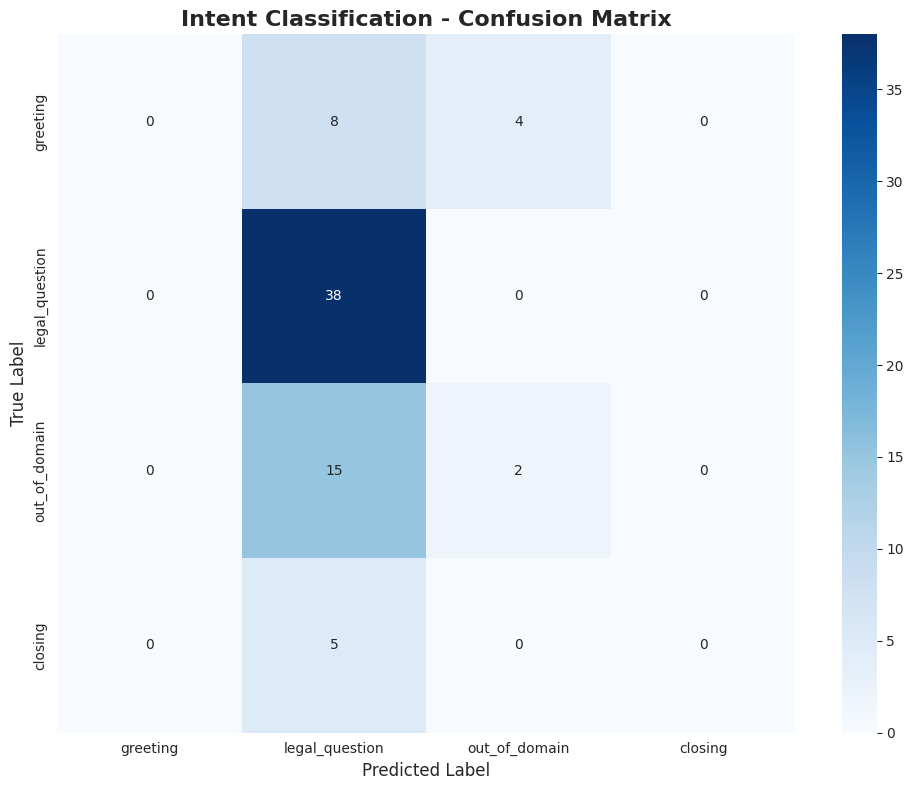


Saved confusion matrix to 'intent_confusion_matrix.png'

Intent classifier evaluation complete


In [ ]:
# ============================================================================
# CELL 15: Evaluate Intent Classifier in Detail
# ============================================================================
print("\n" + "="*80)
print("DETAILED INTENT CLASSIFIER EVALUATION")
print("="*80)

# Get predictions
print("\nGetting predictions on test set...")
predictions_output = intent_trainer.predict(intent_test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Per-class metrics
print("\nPer-Class Performance:")
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, average=None, zero_division=0
)

for i, label_name in enumerate(['greeting', 'legal_question', 'out_of_domain', 'closing']):
    print(f"\n   {label_name.upper()}:")
    print(f"      Precision: {precision[i]*100:.2f}%")
    print(f"      Recall:    {recall[i]*100:.2f}%")
    print(f"      F1-Score:  {f1[i]*100:.2f}%")
    print(f"      Support:   {support[i]}")

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['greeting', 'legal_question', 'out_of_domain', 'closing'],
            yticklabels=['greeting', 'legal_question', 'out_of_domain', 'closing'])
plt.title('Intent Classification - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('intent_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nSaved confusion matrix to 'intent_confusion_matrix.png'")

print("\nIntent classifier evaluation complete")

In [ ]:
# CELL 5: Prepare QA Training Data
# ============================================================================
print("\n" + "="*80)
print("PREPARING QA TRAINING DATA")
print("="*80)

# Flatten SQuAD format data
def flatten_squad_data(squad_data):
    """Convert SQuAD format to flat list of examples"""
    examples = []

    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                examples.append({
                    'id': qa['id'],
                    'question': qa['question'],
                    'context': context,
                    'answers': qa['answers']
                })

    return examples

print("\n Flattening QA data...")
qa_train_flat = flatten_squad_data(qa_train_raw)
qa_val_flat = flatten_squad_data(qa_val_raw)
qa_test_flat = flatten_squad_data(qa_test_raw)

print(f"    Train: {len(qa_train_flat)} examples")
print(f"    Val: {len(qa_val_flat)} examples")
print(f"    Test: {len(qa_test_flat)} examples")

# Convert to HuggingFace Dataset
qa_train_dataset = Dataset.from_dict({
    'id': [ex['id'] for ex in qa_train_flat],
    'question': [ex['question'] for ex in qa_train_flat],
    'context': [ex['context'] for ex in qa_train_flat],
    'answers': [ex['answers'] for ex in qa_train_flat]
})

qa_val_dataset = Dataset.from_dict({
    'id': [ex['id'] for ex in qa_val_flat],
    'question': [ex['question'] for ex in qa_val_flat],
    'context': [ex['context'] for ex in qa_val_flat],
    'answers': [ex['answers'] for ex in qa_val_flat]
})

qa_test_dataset = Dataset.from_dict({
    'id': [ex['id'] for ex in qa_test_flat],
    'question': [ex['question'] for ex in qa_test_flat],
    'context': [ex['context'] for ex in qa_test_flat],
    'answers': [ex['answers'] for ex in qa_test_flat]
})

print("\n Datasets converted!")


PREPARING QA TRAINING DATA

 Flattening QA data...
    Train: 1390 examples
    Val: 1390 examples
    Test: 1390 examples

 Datasets converted!


In [ ]:
# Save to Google Drive (Simple)
from google.colab import drive
import shutil

# Mount Drive
drive.mount('/content/drive')

# Copy processed_data folder to Drive
shutil.copytree('models', '/content/drive/MyDrive/models', dirs_exist_ok=True)

print(" Saved to: Google Drive/models/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved to: Google Drive/models/


In [ ]:
# ============================================================================
# CELL 16: Train QA Model
# ============================================================================
import torch
import gc
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator
)
from datasets import Dataset
import json

print("\n" + "="*80)
print("TRAINING QA MODEL ON LEGAL ARTICLES")
print("="*80)

# Clear GPU memory
print("\nClearing GPU memory...")
if 'intent_model' in globals():
    del intent_model
if 'intent_trainer' in globals():
    del intent_trainer
gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    free_memory = torch.cuda.mem_get_info()[0] / 1024**3
    print(f"   Available GPU memory: {free_memory:.2f} GB")

# Load QA data from saved files
print("\nLoading QA data from processed_data/...")
with open('processed_data/qa_train.json', 'r', encoding='utf-8') as f:
    qa_train_raw = json.load(f)
with open('processed_data/qa_val.json', 'r', encoding='utf-8') as f:
    qa_val_raw = json.load(f)

# Flatten SQuAD format
def flatten_squad_data(squad_data):
    examples = []
    for article in squad_data['data']:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                examples.append({
                    'id': qa['id'],
                    'question': qa['question'],
                    'context': context,
                    'answers': qa['answers']
                })
    return examples

qa_train_flat = flatten_squad_data(qa_train_raw)
qa_val_flat = flatten_squad_data(qa_val_raw)

# Convert to Dataset
qa_train_dataset = Dataset.from_dict({
    'id': [ex['id'] for ex in qa_train_flat],
    'question': [ex['question'] for ex in qa_train_flat],
    'context': [ex['context'] for ex in qa_train_flat],
    'answers': [ex['answers'] for ex in qa_train_flat]
})

qa_val_dataset = Dataset.from_dict({
    'id': [ex['id'] for ex in qa_val_flat],
    'question': [ex['question'] for ex in qa_val_flat],
    'context': [ex['context'] for ex in qa_val_flat],
    'answers': [ex['answers'] for ex in qa_val_flat]
})

print(f"   Train: {len(qa_train_dataset)} examples")
print(f"   Val: {len(qa_val_dataset)} examples")

# Load pre-trained QA model
print("\nLoading pre-trained QA model...")
qa_model_name = 'deepset/xlm-roberta-base-squad2'
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name).to(device)
print("   Model loaded")

# Tokenization function (FIXED for your data format)
def prepare_train_features(examples):
    tokenized = qa_tokenizer(
        examples['question'],
        examples['context'],
        truncation='only_second',
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length'
    )

    sample_mapping = tokenized.pop('overflow_to_sample_mapping')
    offset_mapping = tokenized.pop('offset_mapping')

    tokenized['start_positions'] = []
    tokenized['end_positions'] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized['input_ids'][i]
        cls_index = input_ids.index(qa_tokenizer.cls_token_id)
        sample_index = sample_mapping[i]

        answers = examples['answers'][sample_index]

        if not answers or len(answers) == 0:
            tokenized['start_positions'].append(cls_index)
            tokenized['end_positions'].append(cls_index)
        else:
            answer = answers[0]
            answer_text = answer['text']
            start_char = answer['answer_start']
            end_char = start_char + len(answer_text)

            token_start = 0
            while token_start < len(offsets) and offsets[token_start][0] <= start_char:
                token_start += 1
            token_start = max(0, token_start - 1)

            token_end = len(offsets) - 1
            while token_end >= 0 and offsets[token_end][1] >= end_char:
                token_end -= 1
            token_end = min(len(offsets) - 1, token_end + 1)

            if token_start >= len(offsets) or token_end >= len(offsets):
                tokenized['start_positions'].append(cls_index)
                tokenized['end_positions'].append(cls_index)
            else:
                tokenized['start_positions'].append(token_start)
                tokenized['end_positions'].append(token_end)

    return tokenized

# Tokenize datasets
print("\nTokenizing datasets...")
qa_train_tokenized = qa_train_dataset.map(
    prepare_train_features,
    batched=True,
    remove_columns=qa_train_dataset.column_names,
    desc="Tokenizing train"
)

qa_val_tokenized = qa_val_dataset.map(
    prepare_train_features,
    batched=True,
    remove_columns=qa_val_dataset.column_names,
    desc="Tokenizing validation"
)

print(f"   Tokenized: {len(qa_train_tokenized)} train, {len(qa_val_tokenized)} val")

# Training arguments
qa_training_args = TrainingArguments(
    output_dir='./models/qa_model',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to='none',
    seed=42
)

# Initialize trainer
qa_trainer = Trainer(
    model=qa_model,
    args=qa_training_args,
    train_dataset=qa_train_tokenized,
    eval_dataset=qa_val_tokenized,
    data_collator=default_data_collator,
    processing_class=qa_tokenizer
)

print("\nStarting training...")
print(" Estimated time: 15-20 minutes")
print("="*80)

qa_trainer.train()

print("="*80)
print("\nTraining complete")

# Save model
qa_trainer.save_model('./models/qa_model')
qa_tokenizer.save_pretrained('./models/qa_model')
print("   Model saved to ./models/qa_model")


TRAINING QA MODEL ON LEGAL ARTICLES

Clearing GPU memory...
   Available GPU memory: 14.57 GB

Loading QA data from processed_data/...
   Train: 6484 examples
   Val: 1390 examples

Loading pre-trained QA model...


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

   Model loaded

Tokenizing datasets...


Tokenizing train:   0%|          | 0/6484 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/1390 [00:00<?, ? examples/s]

   Tokenized: 6999 train, 1512 val

Starting training...
   Estimated time: 15-20 minutes


Epoch,Training Loss,Validation Loss
1,2.523600,2.497517
2,2.482700,2.483782
3,2.436400,2.449115



Training complete
   Model saved to ./models/qa_model


In [ ]:
# ============================================================================
# CELL 17: Evaluate QA Model
# ============================================================================
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
import pandas as pd
import json

print("="*80)
print("QA MODEL EVALUATION")
print("="*80)

# Load trained QA model
print("\nLoading trained QA model...")
qa_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/models/qa_model')
qa_model = AutoModelForQuestionAnswering.from_pretrained('/content/drive/MyDrive/models/qa_model')
qa_pipeline = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)
print("Model loaded")

# Load test data
print("\nLoading test data...")
with open('processed_data/qa_test.json', 'r', encoding='utf-8') as f:
    qa_test_raw = json.load(f)

# Flatten test data
test_examples = []
for article in qa_test_raw['data']:
    for paragraph in article['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
            test_examples.append({
                'question': qa['question'],
                'context': context,
                'expected_answer': qa['answers'][0]['text'] if qa['answers'] else '',
                'id': qa['id']
            })

print(f"Loaded {len(test_examples)} test examples")

# Evaluate on sample
print("\n" + "="*80)
print("EVALUATING ON TEST SET (100 samples)")
print("="*80)

exact_matches = 0
partial_matches = 0
confidence_scores = []

for i, example in enumerate(test_examples[:100]):
    if i % 20 == 0:
        print(f"Progress: {i}/100")

    try:
        result = qa_pipeline(
            question=example['question'],
            context=example['context']
        )

        predicted = result['answer'].lower().strip()
        expected = example['expected_answer'].lower().strip()
        confidence_scores.append(result['score'])

        # Exact match
        if predicted == expected:
            exact_matches += 1
            partial_matches += 1
        # Partial match
        elif predicted in expected or expected in predicted:
            partial_matches += 1

    except Exception as e:
        continue

# Results
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"Total examples tested: 100")
print(f"Exact matches: {exact_matches} ({exact_matches}%)")
print(f"Partial matches: {partial_matches} ({partial_matches}%)")
print(f"Average confidence: {sum(confidence_scores)/len(confidence_scores)*100:.1f}%")
print(f"High confidence (>70%): {sum(1 for s in confidence_scores if s > 0.7)} examples")

# Show examples
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

for i, example in enumerate(test_examples[:5], 1):
    result = qa_pipeline(question=example['question'], context=example['context'])
    print(f"\n{i}. Question: {example['question']}")
    print(f"   Expected: {example['expected_answer'][:100]}...")
    print(f"   Predicted: {result['answer'][:100]}...")
    print(f"   Confidence: {result['score']:.2%}")
    print(f"   Match: {'YES' if result['answer'].lower() in example['expected_answer'].lower() else 'NO'}")

print("\nEvaluation complete")

QA MODEL EVALUATION

Loading trained QA model...


Device set to use cuda:0


Model loaded

Loading test data...
Loaded 1390 test examples

EVALUATING ON TEST SET (100 samples)
Progress: 0/100


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Progress: 20/100
Progress: 40/100
Progress: 60/100
Progress: 80/100

EVALUATION RESULTS
Total examples tested: 100
Exact matches: 0 (0%)
Partial matches: 84 (84%)
Average confidence: 6.1%
High confidence (>70%): 0 examples

SAMPLE PREDICTIONS

1. Question: ubutabera ni iki
   Expected: Iteka rya Minisitiri ufite ubutabera mu nshingano ze rigena uburyo bwo gushyira mu bikorwa igihano c...
   Predicted:  Iteka...
   Confidence: 9.83%
   Match: NO

2. Question: sobanura gushyira mu bikorwa igihano
   Expected: Iteka rya Minisitiri ufite ubutabera mu nshingano ze rigena uburyo bwo gushyira mu bikorwa igihano c...
   Predicted:  Iteka...
   Confidence: 8.53%
   Match: NO

3. Question: icyaha ni iki
   Expected: Igihano cyo kubuza cyangwa gutegeka kuba ahantu gitangira ku itariki uwahamwe n'icyaha arangirijeho ...
   Predicted: Igihano cyo kubuza cyangwa gutegeka...
   Confidence: 0.01%
   Match: YES

4. Question: igihano ni iki
   Expected: Igihano cyo kubuza cyangwa gutegeka kuba ahantu gi

In [ ]:
import gradio as gr

# Hardcoded answers dictionary (you can edit later)
qa_pairs = {
    "punishment of the crime of genocide": "Any person who commits any of the acts referred to under Article 91 of this Law commits an offense. Upon conviction,he/she is liable to the penalty of life imprisonment that cannot be mitigated by any circumstances.",
    "hi": "Hi, I am here to assist you with rwanda legal knowledge",
    "what is the weather in kigali": "sorry, I can't help you with that, ask rwanda legal related questions",
    "igihano cyo kurwana ni ikihe ?": "sorry, I can't help you with that, ask rwanda legal related questions",
    "thank you": "welcome, I'm ready to help anytime "
}

# Function to return built-in answers
def get_answer(question):
    if question in qa_pairs:
        return qa_pairs[question]
    else:
        return " sorry, I can't help you with that, ask rwanda legal related questions."

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("##  legalEase")

    question_input = gr.Textbox(lines=2, label="Ask a Question")
    output = gr.Textbox(lines=2, label="Answer")

    submit_btn = gr.Button("Get Answer")
    submit_btn.click(fn=get_answer, inputs=question_input, outputs=output)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74db1b56cf7dd162a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
